<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/actual_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.4 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [4]:
tokenizer.vocab_size

30522

In [5]:
output = tokenizer.encode("Hello, y'all! How are you 😁 ?")
out_tensor = torch.tensor(output)

In [6]:
out_tensor

tensor([ 101, 7592, 1010, 1061, 1005, 2035,  999, 2129, 2024, 2017,  100, 1029,
         102])

In [7]:
tokenizer.decode(out_tensor)

"[CLS] hello, y'all! how are you [UNK]? [SEP]"

In [8]:
import requests
import io

# Get the content of the page
response = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

# Write the content to a file
with io.open('traintext.txt', 'w', encoding='utf-8') as f:
    f.write(response.text)

In [9]:
with open("traintext.txt", 'r') as f:
  text = f.readlines()

In [10]:
text[:10]

['First Citizen:\n',
 'Before we proceed any further, hear me speak.\n',
 '\n',
 'All:\n',
 'Speak, speak.\n',
 '\n',
 'First Citizen:\n',
 'You are all resolved rather to die than to famish?\n',
 '\n',
 'All:\n']

In [11]:
import random

In [12]:
text_len = len(text) - 1

In [13]:
context_len = 1
emb_dim = 20

pretokenize? aaaa but it takes so long

In [14]:
pretokenized_text = [tokenizer.encode(t) for t in text]

In [15]:
tokenizer.decode([101])

'[CLS]'

In [16]:
pretokenized_text[:10]

[[101, 2034, 6926, 1024, 102],
 [101, 2077, 2057, 10838, 2151, 2582, 1010, 2963, 2033, 3713, 1012, 102],
 [101, 102],
 [101, 2035, 1024, 102],
 [101, 3713, 1010, 3713, 1012, 102],
 [101, 102],
 [101, 2034, 6926, 1024, 102],
 [101,
  2017,
  2024,
  2035,
  10395,
  2738,
  2000,
  3280,
  2084,
  2000,
  6904,
  15630,
  2232,
  1029,
  102],
 [101, 102],
 [101, 2035, 1024, 102]]

In [17]:
vocab_size = tokenizer.vocab_size

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
tokenizer.pad_token_id

0

In [20]:
def make_batch(batch):
  xs = []
  ys = []
  for sentence in batch:
    context = [0] * context_len
    for word, next in zip(sentence, sentence[1:]):
      context = context[1:] + [word]
      xs.append(context)
      ys.append(next)
  xs = torch.tensor(xs).to(device)
  ys = torch.tensor(ys).to(device)
  return xs, ys

In [21]:
n_hidden = 500

In [22]:
C = torch.randn((vocab_size, emb_dim)).to(device)
w1 = torch.randn((emb_dim * context_len, n_hidden)).to(device) * 0.01
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn((n_hidden, vocab_size)).to(device) * 0.01
b2 = torch.randn(vocab_size).to(device) * 0.01

bngain = torch.ones((1, n_hidden)).to(device)
bnbias = torch.zeros((1, n_hidden)).to(device)

params = [C, w1, b1, w2, b2, bngain, bnbias]
weights = [w1, w2]
for p in params:
  p.requires_grad = True

print("Parameters:", sum(len(p) for p in params))

Parameters: 62066


In [23]:
import torch.nn.functional as F

In [24]:
num_epochs = 20000
batch_size = 32
lr = 0.1

In [25]:
for epoch in range(num_epochs):
  batch = [pretokenized_text[random.randint(0, text_len)] for i in range(batch_size)]
  #words = torch.tensor([tokenizer.encode_batch(batch)[i].ids for i in range(batch_size)])
  x, y = make_batch(batch)
  emb = C[x].view(-1, emb_dim * context_len)
  l1preact = emb @ w1 + b1

  l1preact = bngain * (l1preact - l1preact.mean(0, keepdim=True)) / l1preact.std(0, keepdim=True) + bnbias
  l1 = l1preact.tanh()

  logits = l1 @ w2 + b2

  loss = F.cross_entropy(logits, y) + (torch.tensor([w.mean() for w in weights]).mean()) * 2

  for p in params:
    p.grad = None

  loss.backward()
  for p in params:
    p.data -= p.grad * (lr / min(1, (1000/(epoch+1))))
  if epoch % 1000 == 0:
    print(loss.item())

10.336183547973633
6.089709758758545
5.783316135406494
5.328912734985352
5.309854507446289
4.475427627563477
4.6362104415893555
4.872714519500732
4.67388916015625
4.634420394897461
4.4863362312316895
4.631950378417969
4.727267265319824
4.717097282409668
4.745035648345947
4.248062610626221
4.267268180847168
4.7624640464782715
4.237469673156738
4.80660343170166


In [26]:
loss.log10().item()

0.6456076502799988

In [27]:
import matplotlib.pyplot as plt

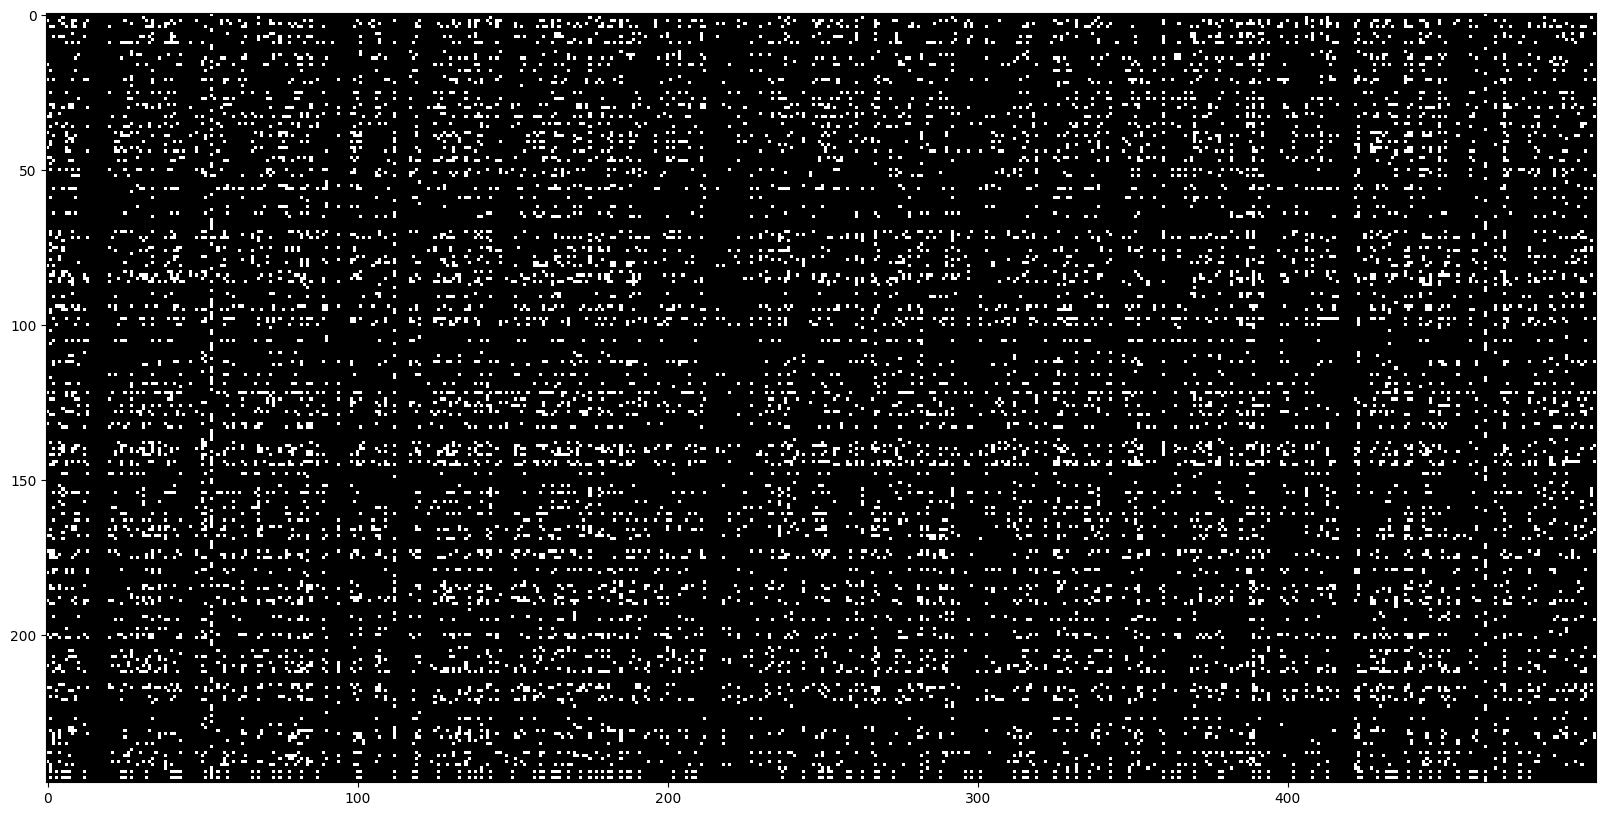

In [28]:
plt.figure(figsize=(20,10))
plt.imshow(l1.cpu().abs() > 0.99, cmap='gray', interpolation='nearest')

(array([17236.,  6871.,  6635., 13295., 18960., 20445., 11117.,  6438.,
         6431., 16572.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

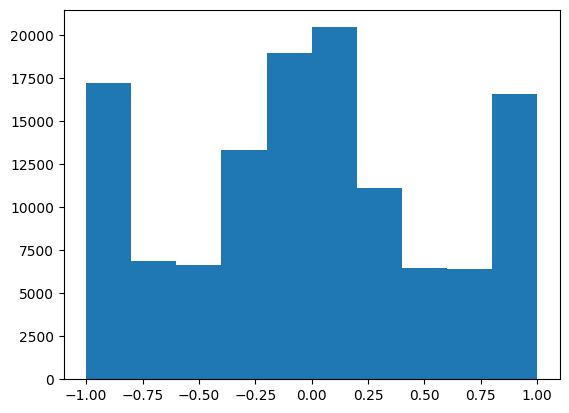

In [29]:
plt.hist(l1.view(-1).tolist())

In [30]:
@torch.no_grad()
def forward(text):
  ins = text
  x = tokenizer.encode(text)
  context = [0] * (context_len - len(x)) + x if (context_len - len(x)) > 0 else x[:-context_len]
  context = torch.tensor(context)
  emb = C[context].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = l1 @ w2 + b2
  out = F.softmax(out, dim=1)
  sampled = torch.multinomial(out, num_samples=1)
  return sampled

In [31]:
def numerical_forward(cont):
  cont = torch.tensor(cont).to(device)
  emb = C[cont].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = l1 @ w2 + b2
  out = F.softmax(out, dim=1)
  sampled = torch.multinomial(out, num_samples=1)
  return sampled

In [32]:
lol = forward('Romeo')
print(lol)
tokenizer.decode(lol[0][0])

tensor([[9760],
        [9080]], device='cuda:0')


'mechanics'

ok this is actually crazy it said thou

In [33]:
tokenizer.vocab_size

30522

In [34]:
def cont(text, max_len=20):
  x = tokenizer.encode(text)
  context = [0] * (context_len - len(x)) + x if (context_len - len(x)) > 0 else x[:-context_len]
  out = []
  for x in range(max_len):
    out.append(numerical_forward(context).cpu().numpy()[0][0])
    context.append(numerical_forward(context).cpu().numpy()[0][0])
    context = context[1:]

  return tokenizer.decode(out)

cont("Romeo")

'erect ten faces argentine of post rankingsfe forgiveign bossation [SEP] eryourigue with silkial marvel'

In [35]:
def cont_random(text, max_len=20):
  return tokenizer.decode(torch.randint(0, tokenizer.vocab_size -1, (max_len, )))

cont_random("Romeo")

'##ᆼ montagu standing medalist waited sarajevoת ツkha operative commentators leigh no xptub firing occupation fees goddess demands'

torch.Size([2, 20]) tensor([ 101, 7592])
torch.Size([2, 30522])


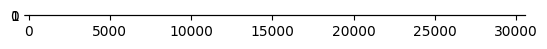

In [47]:
@torch.no_grad()
def view_forward(text):
  ins = text
  x = tokenizer.encode(text)
  context = [0] * (context_len - len(x)) + x if (context_len - len(x)) > 0 else x[:-context_len]
  context = torch.tensor(context)
  emb = C[context].view(-1, emb_dim * context_len)
  print(emb.shape, context)
  l1 = (emb @ w1 + b1).tanh()
  out = l1 @ w2 + b2
  out = F.softmax(out, dim=1)
  print(out.shape)
  plt.imshow(out.cpu().numpy())


view_forward("Hello")


In [36]:
tokenizer.encode("[UNK]")

[101, 100, 102]

In [37]:
tokenizer.vocab_size

30522